In [50]:
# Import dependencies and setup
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

In [51]:
# Reflect Tables into SQLAlchemy ORM
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [52]:
# Set engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [53]:
# Reflect database
Base = automap_base()

# Reflect tables
Base.prepare(engine, reflect=True)

In [54]:
# View reflected table names
Base.classes.keys()

['measurement', 'station']

In [55]:
# Save each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [56]:
# Create session 
session = Session(engine)

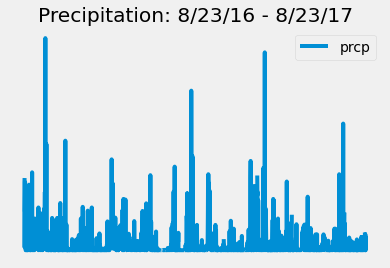

In [144]:
# Exploratory Climate Analysis

# Query for dates and find latest
latest_date = (session.query(Measurement.date)
                     .order_by(Measurement.date.desc())
                     .first())

# Extract string from query object
latest_date = list(np.ravel(latest_date))[0]

# Convert date string to datetime object
latest_date = dt.datetime.strptime(latest_date, '%Y-%m-%d')

#extract year, month, and day as integers
latest_year = int(dt.datetime.strftime(latest_date, '%Y'))
latest_month = int(dt.datetime.strftime(latest_date, '%m'))
latest_day = int(dt.datetime.strftime(latest_date, '%d'))

# Calculate one year before latest date
year_before = dt.date(latest_year, latest_month, latest_day) - dt.timedelta(days=365)

# Query for dates and precipitation for the latest year
rain_data = (session.query(Measurement.date, Measurement.prcp)
                  .filter(Measurement.date > year_before)
                  .order_by(Measurement.date)
                  .all())

# Convert query object to data frame and set index
rain_table = pd.DataFrame(rainData)
rain_table = rain_table.rename(columns={0: "Date", 1: "prcp"})
rain_table = rain_table.set_index('Date')

# Sort by date
rain_table = rain_table.sort_index(ascending=True)

# Plot data with pandas
rain_table.plot(title="Precipitation: 8/23/16 - 8/23/17")
plt.axis('off')
plt.savefig("/Users/minoperic/Data Analytics/Homework/sql-alchemy-challenge/Images/precipitation.png", dpi=72)

In [98]:
# Summarize the data
rainTable.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [124]:
# Query for station count
stations_count = session.query(Station).count()
print(f"Station Count: {stations_count}")

Station Count: 9


In [125]:
# Query for the number of observations per station
station_counts = (session.query(Measurement.station, func.count(Measurement.station))
                        .group_by(Measurement.station)
                        .order_by(func.count(Measurement.station).desc())
                        .all())
station_counts

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [126]:
# Set most active station
station_ID = station_counts[0][0]

# Query for station name
station_name = (session.query(Station.name)
                      .filter_by(station = stationID))
station_name = station_name[0][0]
print(f"The most active station is {station_ID}: {station_name}.")

# Query for highest temperature
highest_temp = (session.query(Measurement.tobs)
                      .filter(Measurement.station == stationID)
                      .order_by(Measurement.tobs.desc())
                      .first())
highest_temp = highest_temp[0]
print(f"The highest temperature recorded there is {highest_temp} degrees Farenheit.")

# Query for lowest temperature
lowest_temp = (session.query(Measurement.tobs)
                     .filter(Measurement.station == stationID)
                     .order_by(Measurement.tobs.asc())
                     .first())
lowest_temp = lowest_temp[0]
print(f"The lowest temperature recorded there is {lowest_temp} degrees Farenheit.")

# Query for average temperature
avg_temp = (session.query(func.avg(Measurement.tobs))
                  .filter(Measurement.station == stationID))
avg_temp = '{0:.3}'.format(avg_temp[0][0])
print(f"The average temperature recorded there is {avgTemp} degrees Farenheit.")

The most active station is USC00519281: WAIHEE 837.5, HI US.
The highest temperature recorded there is 85.0 degrees Farenheit.
The lowest temperature recorded there is 54.0 degrees Farenheit.
The average temperature recorded there is 71.7 degrees Farenheit.


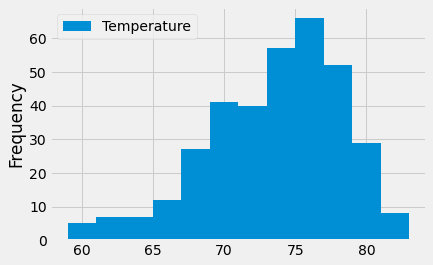

In [145]:
# Query for the last year of temperature data
temp_data = (session.query(Measurement.date, Measurement.tobs)
                   .filter(Measurement.date > year_before)
                   .filter(Measurement.station == station_ID)
                   .order_by(Measurement.date)
                   .all())

# Convert query object to data frame
temp_table = pd.DataFrame(temp_data)
temp_table = temp_table.rename(columns={0: "Date", 1: "Temperature"})
temp_table = temp_table.set_index('Date')

# Sort by date
temp_table = temp_table.sort_index(ascending=True)

# Plot histogram with pandas
temp_table.plot(kind='hist', bins=12)
#plt.savefig("/Users/minoperic/Data Analytics/Homework/sql-alchemy-challenge/Images/temperature.png", dpi=72)

In [128]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [129]:
# Set trip dates and previous dates
trip = '2019-04-08 to \n 2019-04-19'
trip_start_date = '2017-04-08'
trip_end_date = '2017-04-19'

# Calculate the tmin, tavg, and tmax 
trip_temps = calc_temps(trip_start_date, trip_end_date)

trip_temps

[(67.0, 73.6, 83.0)]

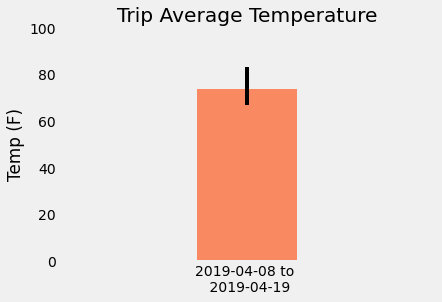

In [146]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

min_trip_temp = trip_temps[0][0]
avg_trip_temp = trip_temps[0][1]
max_trip_temp = trip_temps[0][2]

min_error = avg_trip_temp - min_trip_temp
max_error = max_trip_temp - avg_trip_temp

error_bars = np.array([[min_error], [max_error]])

plt.bar(trip, avg_trip_temp, yerr=error_bars, color = 'orangered', alpha = .6)
plt.ylim(0, 100)
plt.xlim(-1.5, 1.5)
plt.title('Trip Average Temperature')
plt.ylabel('Temp (F)')
plt.grid(alpha=.3)
#plt.savefig("/Users/minoperic/Data Analytics/Homework/sql-alchemy-challenge/Images/trip_average_temperature.png", dpi=72)

In [135]:
# Query for precipitation per station on trip dates
selection = ([Station.station, 
        Station.name, 
        func.sum(Measurement.prcp), 
        Station.latitude, 
        Station.longitude, 
        Station.elevation
       ])

station_rain = (session.query(*selection)
                   .filter(Station.station == Measurement.station)
                   .filter(Measurement.date >= trip_start_date)
                   .filter(Measurement.date <= trip_end_date)
                   .group_by(Station.station)
                   .order_by(func.sum(Measurement.prcp).desc())
                   .all())

# Convert query object to data frame
station_rain_table = pd.DataFrame(np.array(station_rain))

# Rename columns
station_rain_table = station_rain_table.rename(columns={0: "Station", 1: "Location", 
                                                    2: "Total Precipitation", 3: "Latitude", 
                                                    4: "Longitude", 5: "Elevation"})

station_rain_table

,Station,Location,Total Precipitation,Latitude,Longitude,Elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",7.38,21.3331,-157.8025,152.4
1,USC00519281,"WAIHEE 837.5, HI US",6.979999999999999,21.45167,-157.84888999999998,32.9
2,USC00513117,"KANEOHE 838.1, HI US",2.48,21.4234,-157.8015,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.86,21.5213,-157.8374,7.0
4,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.8099999999999999,21.33556,-157.71139,19.5
5,USC00519397,"WAIKIKI 717.2, HI US",0.31000000000000005,21.2716,-157.8168,3.0
6,USC00517948,"PEARL CITY, HI US",0.0,21.3934,-157.9751,11.9


In [136]:
# Optional Challenge Assignment

# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [138]:
# Set the start and end date for the trip
start_date = "2019-04-08"
end_date = "2019-04-19"

# Calculate trip length
start_number = int(start_date[-2:])
end_number = int(end_date[-2:])
trip_length = end_number - start_number + 1

# Start date as datetime object
start_date = dt.datetime.strptime(start_date, '%Y-%m-%d')

# List dates (MM-DD) of trip
date_list = [dt.datetime.strftime(start_date + dt.timedelta(days = x), '%m-%d') 
            for x in range(0, trip_length)]

# Calculate normals for each date
trip_normals = [daily_normals(date) for date in date_list]

trip_normals

[[(66.0, 72.10526315789474, 77.0)],
 [(62.0, 71.6140350877193, 78.0)],
 [(64.0, 71.40350877192982, 79.0)],
 [(65.0, 72.49180327868852, 82.0)],
 [(65.0, 72.22413793103448, 80.0)],
 [(64.0, 71.52542372881356, 79.0)],
 [(65.0, 72.75, 81.0)],
 [(61.0, 71.79310344827586, 79.0)],
 [(62.0, 71.55357142857143, 81.0)],
 [(65.0, 71.93103448275862, 77.0)],
 [(67.0, 72.49152542372882, 77.0)],
 [(65.0, 72.42105263157895, 83.0)]]

In [139]:
# Extract normals into a list of lists
trip_normals = [np.array(normal[0]) for normal in trip_normals]

# Convert normals list into a data frame
normals_table = pd.DataFrame(trip_normals)

# Add date column
normals_table["Date"] = date_list

# Set index and rename columns
normals_table = normals_table.set_index("Date")
normals_table = normals_table.rename(columns={0: "Low Temp", 1: "Avg Temp", 2: "High Temp"})

normals_table

,Low Temp,Avg Temp,High Temp
Date,,,
04-08,66.0,72.105263,77.0
04-09,62.0,71.614035,78.0
04-10,64.0,71.403509,79.0
04-11,65.0,72.491803,82.0
04-12,65.0,72.224138,80.0
04-13,64.0,71.525424,79.0
04-14,65.0,72.750000,81.0
04-15,61.0,71.793103,79.0
04-16,62.0,71.553571,81.0


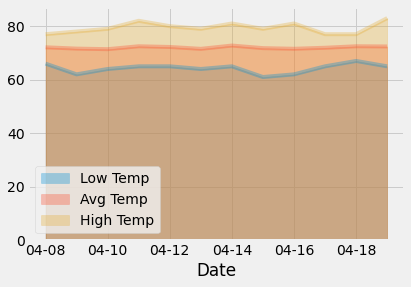

In [147]:
# Plot and save fig 
normals_table.plot.area(stacked=False, alpha=.333)
#plt.savefig("/Users/minoperic/Data Analytics/Homework/sql-alchemy-challenge/Images/low_avg_high_temperature.png", dpi=72)